# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
filtro=2
if filtro==1:
    npzfile = np.load('../conjuntos_datos_nuevos_2020/20_12_2019_comptom_filt.npz')
    npzfile.files
    conjunto_datos_entradasA=npzfile['arr_0']
    conjunto_datos_entradasB=npzfile['arr_1']
    conjunto_datos_salidas=npzfile['arr_2']
else:
    if filtro==2:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/26_12_2019_filt4.npz')
        npzfile.files
        conjunto_datos_entradasA=npzfile['arr_0']
        conjunto_datos_entradasB=npzfile['arr_1']
        conjunto_datos_salidas=npzfile['arr_2']
    else:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
        npzfile.files
        entradas_sensorsA1=npzfile['arr_0']
        entradas_sensorsB1=npzfile['arr_1']
        coordenadas1=npzfile['arr_2']
        entradas_sensorsA2=npzfile['arr_3']
        entradas_sensorsB2=npzfile['arr_4']
        coordenadas2=npzfile['arr_5']
        conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
        conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
        conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (29714, 20, 175)
conjunto_datos_entradas B shape: (29714, 20, 175)
conjunto_datos_salidas shape: (29714, 3)


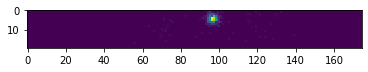

[181.4969897  196.28245542 -35.24111557]


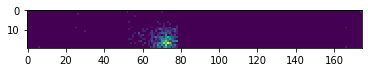

[166.77087194 146.1265914   45.79463196]


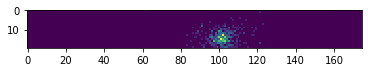

[167.5466638  205.84701211  35.1293335 ]


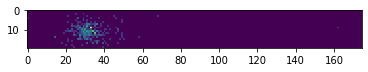

[165.79331126  62.32125662  10.07481575]


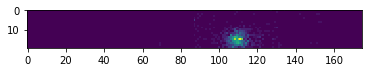

[171.33327257 222.8657208   41.08970642]


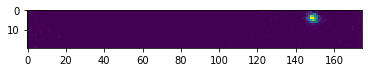

[181.72599788 303.94898093 -38.49809265]


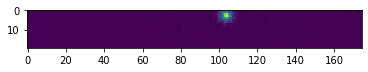

[179.40194102 210.62954804 -47.31930542]


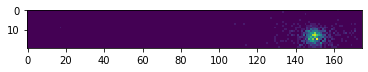

[170.1713784  304.84804678  29.31446838]


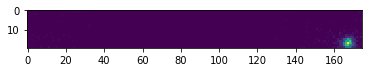

[165.33451793 342.15883302  55.36669922]


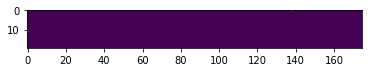

[194.16873989 281.16108326 -64.51516724]


In [4]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_salidas[idea,0:3])

## Network parameters:

In [5]:

batch_size = 250
nb_classes = 10
nb_epoch = 1000

# input image dimensions
img_rows, img_cols = 20, 43
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (2, 4, 4)

## Prepare data into training and test set.

In [6]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2A=np.zeros([muestras,20,175])
veamos2_3A=np.zeros([muestras,20,525])
veamos2B=np.zeros([muestras,20,175])
veamos2_3B=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2A[i]=conjunto_datos_entradasA[i]
    veamos2B[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2A[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    veamos2_3A[i]=np.concatenate((veamos2A[i],veamos2A[i],veamos2A[i]),axis=1) 
    veamos2_3B[i]=np.concatenate((veamos2B[i],veamos2B[i],veamos2B[i]),axis=1) 
    sector2A[i]=veamos2_3A[i,:,indice_inferior:indice_superior]
    sector2B[i]=veamos2_3B[i,:,indice_inferior:indice_superior]      

## data augmentation mediante flip horizontal y vertical

Atencion: la z es copiada pero en realidad es incorrecta. Podemos asegurar que el radio y phi si que son las mismas; pero la z claramente al hacer un flip vertical no puede ser la misma

In [7]:
veamosA=np.zeros([4*muestras,20,img_cols])
veamosB=np.zeros([4*muestras,20,img_cols])
conjunto_datos_salidas_nuevo=np.zeros([4*muestras,3])
for i in range(muestras):
    veamosA[i*4]=sector2A[i]  
    caramba=np.flipud(sector2A[i]) 
    veamosA[i*4+1]=caramba  
    veamosA[i*4+2]=np.fliplr(caramba)     
    veamosA[i*4+3]=np.fliplr(sector2A[i])     
    veamosB[i*4]=sector2B[i]   
    caramba=np.flipud(sector2B[i]) 
    veamosB[i*4+1]=caramba   
    veamosB[i*4+2]=np.fliplr(caramba)  
    veamosB[i*4+3]=np.fliplr(sector2B[i])
    conjunto_datos_salidas_nuevo[i*4]=conjunto_datos_salidas[i]
    conjunto_datos_salidas_nuevo[i*4+1]=conjunto_datos_salidas[i]    
    conjunto_datos_salidas_nuevo[i*4+2]=conjunto_datos_salidas[i]  
    conjunto_datos_salidas_nuevo[i*4+3]=conjunto_datos_salidas[i]  

In [8]:
print('sector A shape:', veamosA.shape)
conjunto_datos_nuevoA=veamosA.reshape(veamosA.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', veamosB.shape)
conjunto_datos_nuevoB=veamosB.reshape(veamosB.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)
print('conjunto_datos_salidas_nuevo:', conjunto_datos_salidas_nuevo.shape)

sector A shape: (118856, 20, 43)
conjunto_datos_nuevo A: (118856, 860)
sector B shape: (118856, 20, 43)
conjunto_datos_nuevo B: (118856, 860)
conjunto_datos_salidas_nuevo: (118856, 3)


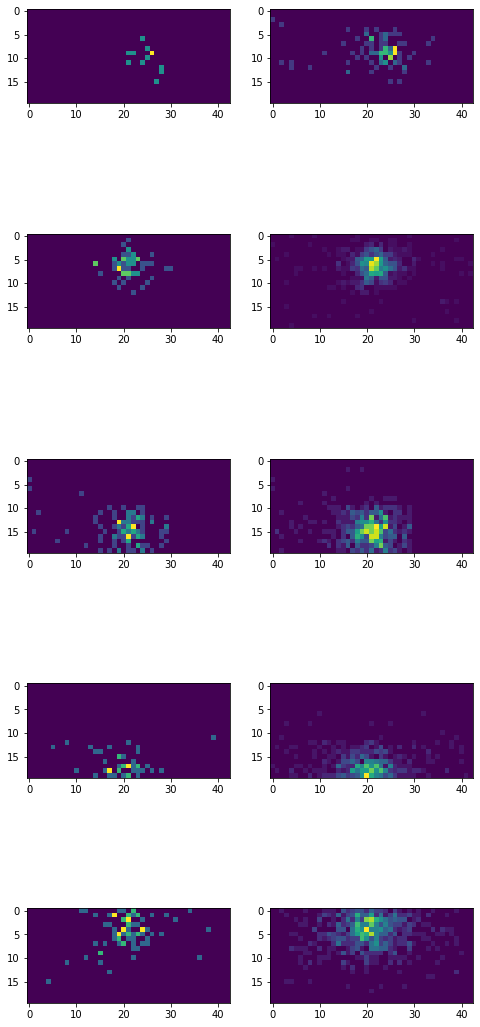

In [9]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


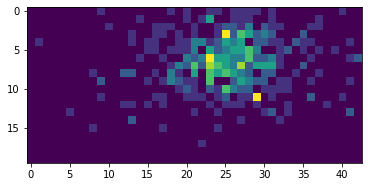

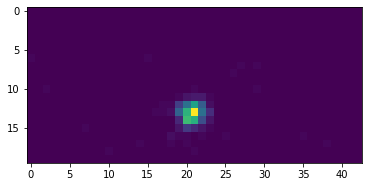

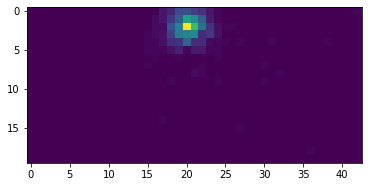

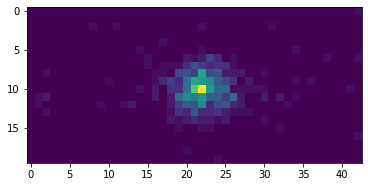

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [11]:
numero_muestras=4*muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas_nuevo,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]









X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)

Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

71313
23771
23772
(10668, 1720)
(5748, 1720)
(4372, 1720)
(2048, 1720)
(936, 1720)


Vamos a normalizar las salidas por si luego nos interea

In [12]:
Y_total=conjunto_datos_nuevo2[:numero_muestras,0]
min_max_scaler = preprocessing.MinMaxScaler().fit(Y_total.reshape(-1, 1))

Y_train_scaled = min_max_scaler.transform(Y_train.reshape(-1, 1))
Y_val_scaled = min_max_scaler.transform(Y_val.reshape(-1, 1))
Y_test_scaled = min_max_scaler.transform(Y_test.reshape(-1, 1))

Y_test_bin4_scaled=min_max_scaler.transform(Y_test_bin4.reshape(-1, 1))
Y_test_bin3_scaled=min_max_scaler.transform(Y_test_bin3.reshape(-1, 1))
Y_test_bin2_scaled=min_max_scaler.transform(Y_test_bin2.reshape(-1, 1))
Y_test_bin1_scaled=min_max_scaler.transform(Y_test_bin1.reshape(-1, 1))
Y_test_bin0_scaled=min_max_scaler.transform(Y_test_bin0.reshape(-1, 1))

In [13]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols,1)

input_shape = (2, img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [14]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (71313, 2, 20, 43, 1)
71313 train samples
23771 validation samples
23772 test samples


## Data augmentation

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True,
                            vertical_flip=True)

In [16]:

# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))

In [17]:
use_regularizer = False
my_regularizer = None
# my_epochs = 50
# hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(0.00001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'



## Build the CNN. 

In [18]:
model = Sequential()

model.add(Conv3D(16, kernel_size=kernel_size,
                        padding='same',
                        kernel_regularizer=my_regularizer,
                        data_format='channels_last',
                        input_shape=(2,img_rows,img_cols,1)))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(16, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv3D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv3D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv3D(128, kernel_size,kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('tanh'))
model.add(Dense(1,use_bias=True, 
                kernel_regularizer=my_regularizer             
               ))


dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}x{}_con_batchnormalization_sector_{}x{}x{}_elu".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
algoritmo='Nadam'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt)
model_check=ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 2, 20, 43, 16)     528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 20, 43, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 2, 20, 43, 16)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 10, 21, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 10, 21, 16)     8208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 10, 21, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 2, 10, 21, 16)     0         
__________

And now train the model and evaluate on the test set. 

In [20]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard,model_check,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 71313 samples, validate on 23771 samples
Epoch 1/1000
71313/71313 [==============================] - 17s 231us/step - loss: 779.4843 - val_loss: 11.3538

Epoch 00001: val_loss improved from inf to 11.35380, saving model to ../redes_CNN_R/models_best/CNN_regression_R_1000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x43x1_elu_Nadam_2019-12-31 11:57:00.h5
Epoch 2/1000
71313/71313 [==============================] - 10s 143us/step - loss: 11.0026 - val_loss: 8.3209

Epoch 00002: val_loss improved from 11.35380 to 8.32090, saving model to ../redes_CNN_R/models_best/CNN_regression_R_1000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x43x1_elu_Nadam_2019-12-31 11:57:00.h5
Epoch 3/1000
71313/71313 [==============================] - 10s 146us/step - loss: 10.3868 - val_loss: 6.8416

Epoch 00003: val_loss improved from 8.32090 to 6.84158, saving model to ../redes_CNN_R/models_best/CNN_regression_R_1000_250_CNN_kernel_2x4x4_c

In [21]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [22]:

# best_model_name='../redes_CNN_R/models_best/CNN_regression_R_1000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_elu_Nadam_2019-12-29 10:55:00.h5'
best_model = load_model(best_model_name)

# best_model = model
score = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=best_model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])

error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

best_model.summary()

Test mse: 4.83352470859301
[172.38214 172.10904 172.1719  172.04648 172.06471 171.63306 171.57935
 171.39624 169.91165 167.29652]
[173.03363647 173.03363647 173.03363647 173.03363647 172.59163044
 172.59163044 172.59163044 172.59163044 168.20943551 168.20943551]
[ 0.65149536  0.92459717  0.86173095  0.9871582   0.52691792  0.9585738
  1.01228474  1.19539021 -1.7022161   0.91291147]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 2, 20, 43, 16)     528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 20, 43, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 2, 20, 43, 16)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 10, 21, 16)     0         
_____________________

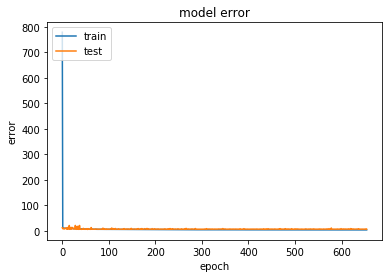

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


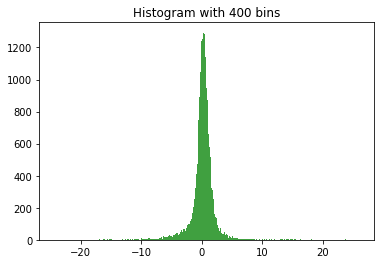

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 400
    # variables        = 3
    chi-square         = 262307.836
    reduced chi-square = 660.725028
    Akaike info crit   = 2600.32380
    Bayesian info crit = 2612.29819
[[Variables]]
    amp:  1231.65011 +/- 9.16049361 (0.74%) (init = 1000)
    cen:  0.21490340 +/- 0.00719568 (3.35%) (init = 0)
    wid:  1.18484051 +/- 0.01017623 (0.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



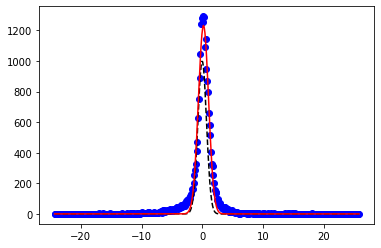

In [25]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [26]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [27]:
print(FWHM)

1.9728888617431213


[[169.91165]
 [167.29652]
 [167.00626]
 ...
 [168.45403]
 [167.553  ]
 [167.54549]]


/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.6683277112472095


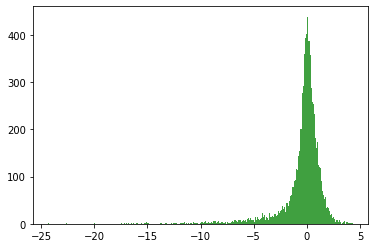

In [28]:
Y_test_bin0_predicted=best_model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


2.1505854193435963


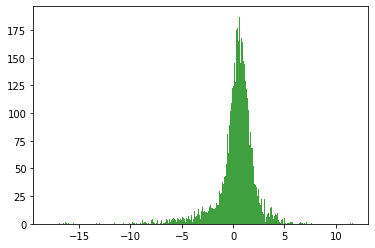

In [29]:
Y_test_bin1_predicted=best_model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.9973032021861623


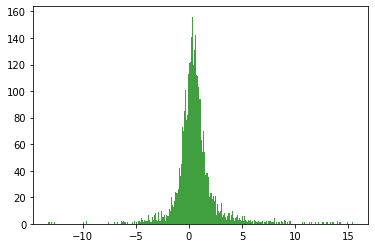

In [30]:
Y_test_bin2_predicted=best_model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.6917428599753717


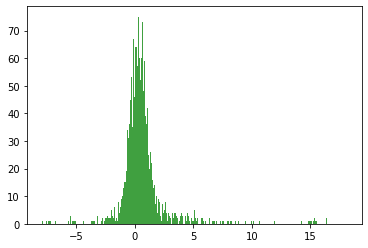

In [31]:
Y_test_bin3_predicted=best_model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

In [ ]:
Y_test_bin4_predicted=best_model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Veamos ahora los histogramnas 2d que nos interesan